### Crop automatique des nodules (avec redimensionnement) + génération des masques

In [ ]:
import os
import glob
import cv2
import json
import xml.etree.ElementTree as ET
import numpy as np

def process_segmentation_annotations(xml_dir, image_dir, output_image_dir, output_mask_dir, target_size=(256, 256), padding_factor=1.5):
    """
    Traite les annotations XML et extrait les régions annotées en images et masques.

    Args:
        xml_dir (str): Répertoire contenant les fichiers XML d'annotations.
        image_dir (str): Répertoire contenant les images d'entrée.
        output_image_dir (str): Répertoire pour enregistrer les images recadrées.
        output_mask_dir (str): Répertoire pour enregistrer les masques recadrés.
        target_size (tuple): Taille cible pour les images et masques recadrés.
        padding_factor (float): Facteur d'agrandissement des boîtes englobantes.
    """
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_mask_dir, exist_ok=True)

    xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))
    print(f"{len(xml_files)} fichiers XML trouvés.")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
        except Exception as e:
            print(f"Erreur lors du parsing de {xml_file} : {e}")
            continue

        root = tree.getroot()
        case_number_elem = root.find('number')
        if case_number_elem is None or case_number_elem.text is None:
            print(f"Numéro de cas introuvable dans {xml_file}.")
            continue
        case_number = case_number_elem.text.strip()

        for mark in root.findall('mark'):
            image_tag = mark.find('image')
            if image_tag is None or image_tag.text is None:
                print(f"Balise <image> manquante dans une annotation de {xml_file}.")
                continue
            image_number = image_tag.text.strip()

            image_filename = f"{case_number}_{image_number}.jpg"
            image_path = os.path.join(image_dir, image_filename)
            if not os.path.exists(image_path):
                print(f"Image {image_path} introuvable.")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Erreur lors du chargement de l'image {image_path}.")
                continue

            svg_elem = mark.find('svg')
            if svg_elem is None or not svg_elem.text:
                print(f"Pas d'annotation SVG trouvée dans {xml_file} pour l'image {image_filename}.")
                continue

            try:
                svg_data = json.loads(svg_elem.text.strip())
            except Exception as e:
                print(f"Erreur lors du parsing du JSON dans {xml_file} pour {image_filename} : {e}")
                continue

            if not isinstance(svg_data, list):
                print(f"Format JSON inattendu dans {xml_file} pour {image_filename}.")
                continue

            for region_idx, region in enumerate(svg_data):
                points_data = region.get("points", [])
                if not points_data:
                    print(f"Aucun point trouvé pour la région {region_idx} dans {image_filename}.")
                    continue

                xs, ys = [], []
                for point in points_data:
                    x_val = point.get("x")
                    y_val = point.get("y")
                    if x_val is not None and y_val is not None:
                        xs.append(x_val)
                        ys.append(y_val)

                if not xs or not ys:
                    print(f"Coordonnées insuffisantes pour la région {region_idx} dans {image_filename}.")
                    continue

                center_x = int(np.mean(xs))
                center_y = int(np.mean(ys))
                points = np.array(list(zip(xs, ys)), dtype=np.int32)
                x, y, w, h = cv2.boundingRect(points)

                side_length = int(max(w, h) * padding_factor)
                half_side = side_length // 2

                x1 = max(center_x - half_side, 0)
                y1 = max(center_y - half_side, 0)
                x2 = min(center_x + half_side, image.shape[1])
                y2 = min(center_y + half_side, image.shape[0])
                cropped = image[y1:y2, x1:x2]

                ch, cw = cropped.shape[:2]
                side = min(ch, cw)
                offset_x = (cw - side) // 2
                offset_y = (ch - side) // 2
                square_crop = cropped[offset_y:offset_y+side, offset_x:offset_x+side].copy()

                resized_crop = cv2.resize(square_crop, target_size, interpolation=cv2.INTER_LANCZOS4)
                output_filename = f"{case_number}_{image_number}_region{region_idx}_cropped.jpg"
                output_path = os.path.join(output_image_dir, output_filename)
                cv2.imwrite(output_path, resized_crop)
                print(f"Image enregistrée : {output_path}")

                mask = np.zeros(image.shape[:2], dtype=np.uint8)
                cv2.fillPoly(mask, [points], 255)
                cropped_mask = mask[y1:y2, x1:x2]
                square_crop_mask = cropped_mask[offset_y:offset_y+side, offset_x:offset_x+side].copy()
                resized_mask = cv2.resize(square_crop_mask, target_size, interpolation=cv2.INTER_NEAREST)

                mask_filename = f"{case_number}_{image_number}_region{region_idx}_mask.jpg"
                mask_path = os.path.join(output_mask_dir, mask_filename)
                cv2.imwrite(mask_path, resized_mask)
                print(f"Masque enregistré : {mask_path}")

if __name__ == "__main__":
    process_segmentation_annotations("../data/annotations", "../data/images", "cropped_images", "cropped_masks")

### Annotation des images non recadrées

In [ ]:
import os
import glob
import cv2
import json
import xml.etree.ElementTree as ET
import numpy as np

def process_annotations(xml_dir, image_dir, output_dir):
    """
    Traite les annotations XML et applique les annotations sur les images correspondantes.

    Args:
        xml_dir (str): Répertoire contenant les fichiers XML d'annotations.
        image_dir (str): Répertoire contenant les images d'entrée.
        output_dir (str): Répertoire où enregistrer les images annotées.
    """
    os.makedirs(output_dir, exist_ok=True)
    xml_files = glob.glob(os.path.join(xml_dir, "*.xml"))
    print(f"{len(xml_files)} fichiers XML trouvés.")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
        except Exception as e:
            print(f"Erreur lors du parsing de {xml_file} : {e}")
            continue

        root = tree.getroot()
        case_number_elem = root.find('number')
        if case_number_elem is None or case_number_elem.text is None:
            print(f"Numéro de cas introuvable dans {xml_file}.")
            continue
        case_number = case_number_elem.text.strip()

        for mark in root.findall('mark'):
            image_tag = mark.find('image')
            if image_tag is None or image_tag.text is None:
                print(f"Balise <image> manquante dans une annotation de {xml_file}.")
                continue
            image_number = image_tag.text.strip()

            image_filename = f"{case_number}_{image_number}.jpg"
            image_path = os.path.join(image_dir, image_filename)
            if not os.path.exists(image_path):
                print(f"Image {image_path} introuvable.")
                continue

            image = cv2.imread(image_path)
            if image is None:
                print(f"Erreur lors du chargement de l'image {image_path}.")
                continue

            svg_elem = mark.find('svg')
            if svg_elem is None or not svg_elem.text:
                print(f"Pas d'annotation SVG trouvée dans {xml_file} pour l'image {image_filename}.")
                continue

            try:
                svg_data = json.loads(svg_elem.text.strip())
            except Exception as e:
                print(f"Erreur lors du parsing du JSON dans {xml_file} pour {image_filename} : {e}")
                continue

            if not isinstance(svg_data, list):
                print(f"Format JSON inattendu dans {xml_file} pour {image_filename}.")
                continue

            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            for region_idx, region in enumerate(svg_data):
                points_data = region.get("points", [])
                if not points_data:
                    print(f"Aucun point trouvé pour la région {region_idx} dans {image_filename}.")
                    continue

                xs, ys = [], []
                for point in points_data:
                    x_coord = point.get("x")
                    y_coord = point.get("y")
                    if x_coord is not None and y_coord is not None:
                        xs.append(x_coord)
                        ys.append(y_coord)

                if not xs or not ys:
                    print(f"Coordonnées insuffisantes pour la région {region_idx} dans {image_filename}.")
                    continue

                pts = np.array(list(zip(xs, ys)), dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(gray_image, [pts], isClosed=True, color=255, thickness=2)

            annotated_filename = f"{case_number}_{image_number}_annotated.jpg"
            annotated_path = os.path.join(output_dir, annotated_filename)
            cv2.imwrite(annotated_path, gray_image)
            print(f"Image annotée enregistrée : {annotated_path}")

# Exécution principale
if __name__ == "__main__":
    process_annotations("../data/annotations", "../data/images", "../data/annotated_images")

### Test de filtrage de l'image

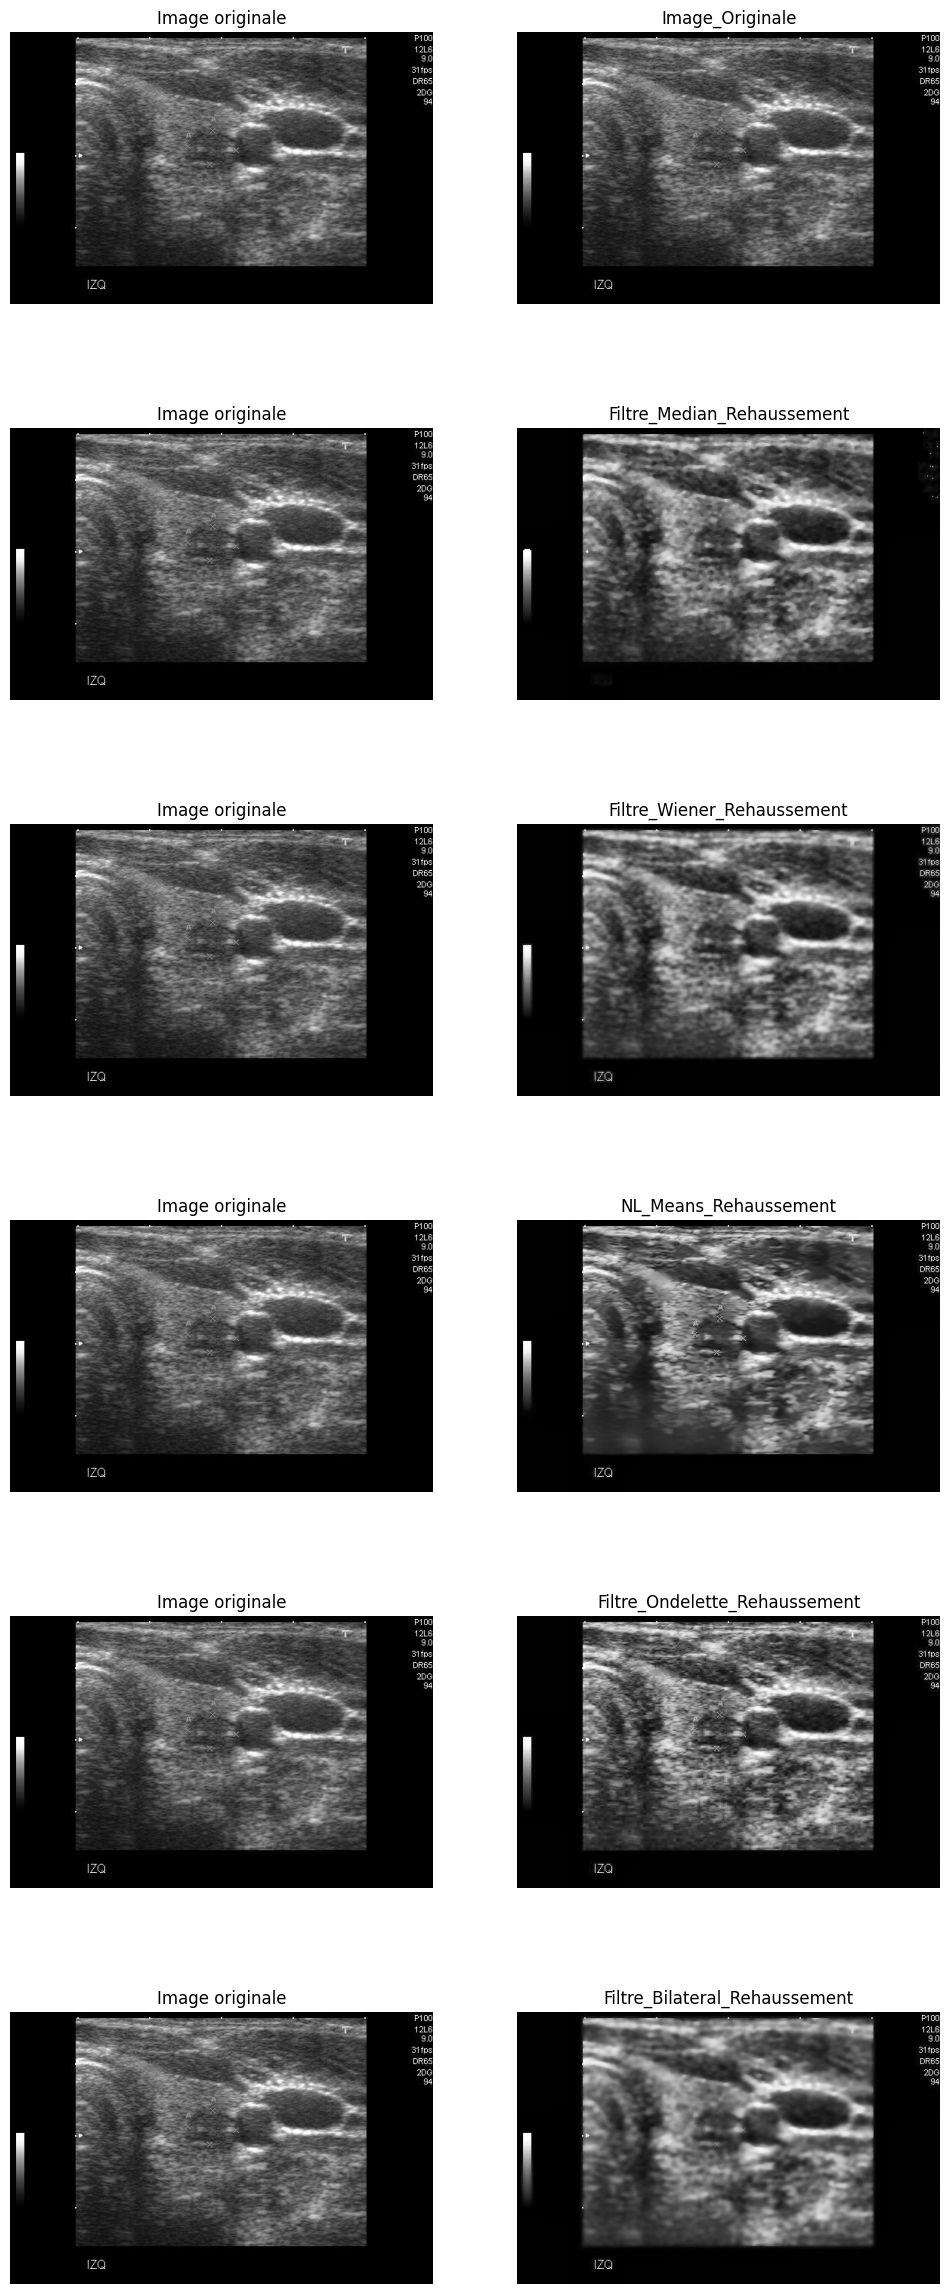

In [33]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os

def load_image(image_path):
    """
    Charge une image en niveaux de gris.

    Args:
        image_path (str): Chemin du fichier image.

    Returns:
        numpy.ndarray: Image en niveaux de gris.
    """
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def apply_median_filter(img, kernel_size=5):
    """
    Applique un filtre médian pour réduire le bruit.

    Args:
        img (numpy.ndarray): Image d'entrée.
        kernel_size (int): Taille du noyau du filtre médian.

    Returns:
        numpy.ndarray: Image filtrée.
    """
    return cv2.medianBlur(img, kernel_size)

def apply_wiener_filter(img, kernel_size=5):
    """
    Applique un filtre de Wiener pour réduire le bruit.

    Args:
        img (numpy.ndarray): Image d'entrée.
        kernel_size (int): Taille du noyau pour le filtrage.

    Returns:
        numpy.ndarray: Image filtrée.
    """
    img_float = img.astype(np.float64)
    local_mean = cv2.blur(img_float, (kernel_size, kernel_size))
    local_var = cv2.blur(img_float**2, (kernel_size, kernel_size)) - local_mean**2
    noise_var = np.var(img_float)
    filtered_img = local_mean + (np.maximum(local_var - noise_var, 0) / (local_var + 1e-10)) * (img_float - local_mean)
    return np.clip(filtered_img, 0, 255).astype(np.uint8)

def apply_nl_means_filter(img, h=10, template_window_size=7, search_window_size=20):
    """
    Applique un filtre NL-Means pour le débruitage.

    Args:
        img (numpy.ndarray): Image d'entrée.
        h (int): Paramètre de filtrage.
        template_window_size (int): Taille de la fenêtre modèle.
        search_window_size (int): Taille de la fenêtre de recherche.

    Returns:
        numpy.ndarray: Image filtrée.
    """
    return cv2.fastNlMeansDenoising(img, None, h, template_window_size, search_window_size)

def apply_wavelet_denoise(img, wavelet='db2', level=2):
    """
    Applique un débruitage basé sur les ondelettes.

    Args:
        img (numpy.ndarray): Image d'entrée.
        wavelet (str): Type d'ondelette.
        level (int): Niveau de décomposition.

    Returns:
        numpy.ndarray: Image filtrée.
    """
    coeffs = pywt.wavedec2(img, wavelet, level=level)
    coeffs_thresh = [coeffs[0]] + [
        tuple(pywt.threshold(detail, np.std(detail) / 2, mode='soft') for detail in coeff) for coeff in coeffs[1:]
    ]
    denoised_img = pywt.waverec2(coeffs_thresh, wavelet)
    return np.clip(denoised_img, 0, 255).astype(np.uint8)

def apply_bilateral_filter(img, d=9, sigma_color=75, sigma_space=75):
    """
    Applique un filtre bilatéral pour lisser l'image tout en préservant les contours.

    Args:
        img (numpy.ndarray): Image d'entrée.
        d (int): Diamètre de la fenêtre du filtre.
        sigma_color (int): Paramètre de filtrage des couleurs.
        sigma_space (int): Paramètre de filtrage spatial.

    Returns:
        numpy.ndarray: Image filtrée.
    """
    return cv2.bilateralFilter(img, d, sigma_color, sigma_space)

def enhance_contrast(img):
    """
    Améliore le contraste d'une image avec CLAHE.

    Args:
        img (numpy.ndarray): Image d'entrée.

    Returns:
        numpy.ndarray: Image avec un contraste amélioré.
    """
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    return clahe.apply(img)

def process_image(image_path, output_dir="filtered_images"):
    """
    Applique plusieurs filtres sur une image et enregistre les résultats.

    Args:
        image_path (str): Chemin de l'image à traiter.
        output_dir (str): Dossier où enregistrer les images filtrées.
    """
    img = load_image(image_path)
    #os.makedirs(output_dir, exist_ok=True)

    filters = {
        "Filtre_Median": apply_median_filter,
        "Filtre_Wiener": apply_wiener_filter,
        "NL_Means": apply_nl_means_filter,
        "Filtre_Ondelette": apply_wavelet_denoise,
        "Filtre_Bilateral": apply_bilateral_filter
    }

    images = [("Image_Originale", img)]

    for name, func in filters.items():
        filtered_img = enhance_contrast(func(img))
        images.append((name + "_Rehaussement", filtered_img))
        #cv2.imwrite(os.path.join(output_dir, name + ".png"), filtered_img)

    # Affichage des résultats
    fig, axes = plt.subplots(len(images), 2, figsize=(12, 30))

    for i, (title, filtered_img) in enumerate(images):
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title("Image originale")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(filtered_img, cmap='gray')
        axes[i, 1].set_title(title)
        axes[i, 1].axis("off")

    plt.show()

image_path = "../data/images/69_2.jpg"
process_image(image_path)

### Application de filtres sur les images recadrées (NL means + rehaussement de contraste CLAHE)

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Chemin du dossier contenant les images d'entrée
input_folder = "../data/cropped_images"

# Chemin du dossier où enregistrer les images filtrées
output_folder = "../data/train_data/cropped_filtered_images"

# Création du dossier de sortie s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

def load_image(image_path):
    """
    Charge une image en niveaux de gris.

    Args:
        image_path (str): Chemin du fichier image.

    Returns:
        numpy.ndarray: Image en niveaux de gris.
    """
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def apply_nl_means_filter(img, h=10, template_window_size=7, search_window_size=21):
    """
    Applique un filtre de réduction de bruit NL-Means à une image.

    Args:
        img (numpy.ndarray): Image d'entrée en niveaux de gris.
        h (int): Paramètre de filtrage pour le débruitage.
        template_window_size (int): Taille de la fenêtre du modèle.
        search_window_size (int): Taille de la fenêtre de recherche.

    Returns:
        numpy.ndarray: Image débruitée.
    """
    return cv2.fastNlMeansDenoising(img, None, h, template_window_size, search_window_size)

def enhance_contrast(img):
    """
    Améliore le contraste d'une image à l'aide de CLAHE.

    Args:
        img (numpy.ndarray): Image d'entrée en niveaux de gris.

    Returns:
        numpy.ndarray: Image avec un contraste amélioré.
    """
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    return clahe.apply(img)

def process_image(image_path, output_folder):
    """
    Traite une image en lui appliquant un filtre NL-Means et un réhaussement du contraste.

    Args:
        image_path (str): Chemin du fichier image d'entrée.
        output_folder (str): Chemin du dossier de sortie.
    """
    img = load_image(image_path)
    if img is None:
        print(f"Erreur : Impossible de charger l'image {image_path}")
        return

    # Appliquer le filtre NL-Means
    denoised_img = apply_nl_means_filter(img)

    # Appliquer le réhaussement de contraste
    enhanced_img = enhance_contrast(denoised_img)

    # Conserver le même nom de fichier dans le dossier de sortie
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)

    # Sauvegarde de l'image filtrée avec le même nom
    cv2.imwrite(output_path, enhanced_img)
    print(f"Image enregistrée : {output_path}")

# Lister toutes les images du dossier et les traiter
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(image_extensions)]

if not image_files:
    print("Aucune image trouvée dans le dossier.")
else:
    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)
        print(f"Traitement de {image_path}...")
        process_image(image_path, output_folder)

    print(f"\n Traitement terminé ! Images enregistrées dans : {output_folder}")


### Entraînement modèle A

In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

class SegmentationDataset(Dataset):
    """
    Dataset personnalisé pour la segmentation d'images.

    Args:
        images_paths (list): Liste des chemins des images.
        masks_paths (list): Liste des chemins des masques.
        transform (callable, optional): Transformation à appliquer aux images et aux masques.
    """
    def __init__(self, images_paths, masks_paths, transform=None):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.transform = transform

    def __len__(self):
        """Retourne le nombre total d'images dans le dataset."""
        return len(self.images_paths)

    def __getitem__(self, idx):
        """Charge et transforme une image et son masque correspondant."""
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = ToTensorV2()(image=image)['image']
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        mask = mask.float() / 255.0  # Normalisation 0-1
        return image, mask

def get_dataloaders(batch_size=8, num_workers=4):
    """
    Charge les images, divise les datasets en ensembles d'entraînement, validation et test,
    et retourne les DataLoaders correspondants.

    Args:
        batch_size (int): Taille des lots.
        num_workers (int): Nombre de processus pour le chargement des données.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    images_paths = sorted(glob.glob(os.path.join("../data/train_data", "cropped_filtered_images", "*.jpg")))
    masks_paths  = sorted(glob.glob(os.path.join("../data/train_data", "cropped_masks", "*.jpg")))

    assert len(images_paths) == len(masks_paths), "Le nombre d'images et de masques doit être identique."

    train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(images_paths, masks_paths, test_size=0.2, random_state=42)
    val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5, random_state=42)

    train_transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
    val_dataset   = SegmentationDataset(val_imgs, val_masks, transform=val_transform)
    test_dataset  = SegmentationDataset(test_imgs, test_masks, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

def create_model():
    """
    Crée et retourne un modèle U-Net avec un encodeur ResNet-50.

    Returns:
        torch.nn.Module: Modèle U-Net.
    """
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    )
    return model

def train_model(model, train_loader, val_loader, device, num_epochs=30, lr=1e-4):
    """
    Entraîne le modèle de segmentation et sauvegarde les poids après l'entraînement.

    Args:
        model (torch.nn.Module): Modèle à entraîner.
        train_loader (DataLoader): DataLoader pour l'entraînement.
        val_loader (DataLoader): DataLoader pour la validation.
        device (torch.device): Périphérique pour l'entraînement (CPU ou GPU).
        num_epochs (int): Nombre d'époques d'entraînement.
        lr (float): Taux d'apprentissage.
    """
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}")

    # Sauvegarde du modèle
    model_save_path = "../models/unet_resnet50.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Modèle sauvegardé à : {model_save_path}")

### Affichage du masque prédit modèle A

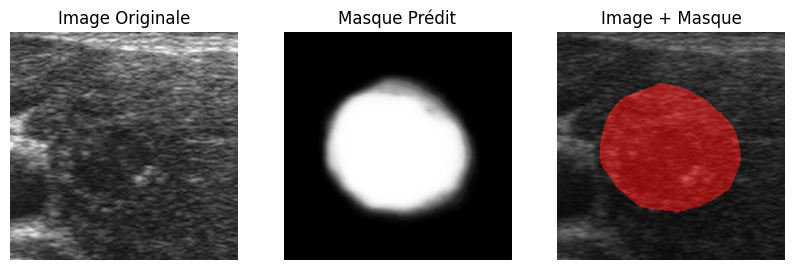

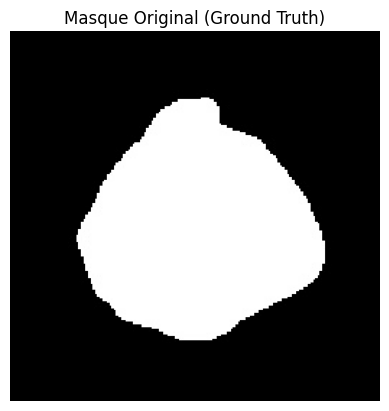

In [39]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os

def load_model(model_path, device):
    """
    Charge un modèle U-Net pré-entraîné pour la segmentation.

    Args:
        model_path (str): Chemin vers le fichier des poids du modèle.
        device (torch.device): Périphérique sur lequel charger le modèle (CPU ou GPU).

    Returns:
        torch.nn.Module: Modèle chargé et mis en mode évaluation.
    """
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def preprocess_image(image_path):
    """
    Pré-traite une image pour l'inférence du modèle.

    Args:
        image_path (str): Chemin de l'image à traiter.

    Returns:
        tuple: Tenseur d'image prêt pour l'inférence, image originale sous forme de tableau NumPy.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    augmented = transform(image=image)
    image_tensor = augmented["image"].unsqueeze(0)
    return image_tensor, image

def predict(model, image_tensor, device):
    """
    Effectue une prédiction de segmentation sur une image donnée.

    Args:
        model (torch.nn.Module): Modèle de segmentation.
        image_tensor (torch.Tensor): Image pré-traitée sous forme de tenseur.
        device (torch.device): Périphérique d'inférence.

    Returns:
        numpy.ndarray: Masque prédit sous forme d'un tableau 2D.
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()[0, 0]
    return output

def overlay_mask(image, mask, alpha=0.5):
    """
    Superpose un masque sur une image d'origine.

    Args:
        image (numpy.ndarray): Image originale.
        mask (numpy.ndarray): Masque prédit.
        alpha (float): Facteur de transparence pour la superposition.

    Returns:
        numpy.ndarray: Image avec le masque superposé.
    """
    mask = (mask > 0.5).astype(np.uint8)
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * 255
    blended = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return blended

def get_ground_truth_mask(original_image_filename):
    """
    Charge le masque de référence (ground truth) correspondant à une image.

    Args:
        original_image_filename (str): Nom du fichier image original.

    Returns:
        numpy.ndarray or None: Masque ground truth normalisé ou None s'il n'existe pas.
    """
    mask_filename = original_image_filename.replace("cropped.jpg", "mask.jpg")
    mask_filepath = os.path.join("../data/train_data/cropped_masks", mask_filename)
    if os.path.exists(mask_filepath):
        return cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE) / 255.0
    return None

def visualize(original, mask, overlay, ground_truth=None):
    """
    Affiche l'image originale, le masque prédit et l'image annotée.

    Args:
        original (numpy.ndarray): Image originale.
        mask (numpy.ndarray): Masque prédit.
        overlay (numpy.ndarray): Image avec superposition du masque.
        ground_truth (numpy.ndarray, optional): Masque ground truth, si disponible.
    """
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Image Originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque Prédit")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Image + Masque")
    plt.axis("off")

    plt.show()

    if ground_truth is not None:
        plt.figure()
        plt.imshow(ground_truth, cmap="gray")
        plt.title("Masque Original (Ground Truth)")
        plt.axis("off")
        plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "../models/unet_resnet50.pth"
    model = load_model(model_path, device)

    test_image_path = "../data/cropped_images/11_1_region0_cropped.jpg"
    image_tensor, original_image = preprocess_image(test_image_path)
    predicted_mask = predict(model, image_tensor, device)
    overlayed_image = overlay_mask(original_image, predicted_mask)

    ground_truth_mask = get_ground_truth_mask(os.path.basename(test_image_path))
    visualize(original_image, predicted_mask, overlayed_image, ground_truth_mask)

### Affichage des performances du modèle A

Dice Score Moyenne: 0.8811
Dice Score Médiane: 0.8966
Dice Score Écart-Type: 0.0646
Dice Score Variance: 0.0042
Iou Score Moyenne: 0.7923
Iou Score Médiane: 0.8126
Iou Score Écart-Type: 0.0845
Iou Score Variance: 0.0071


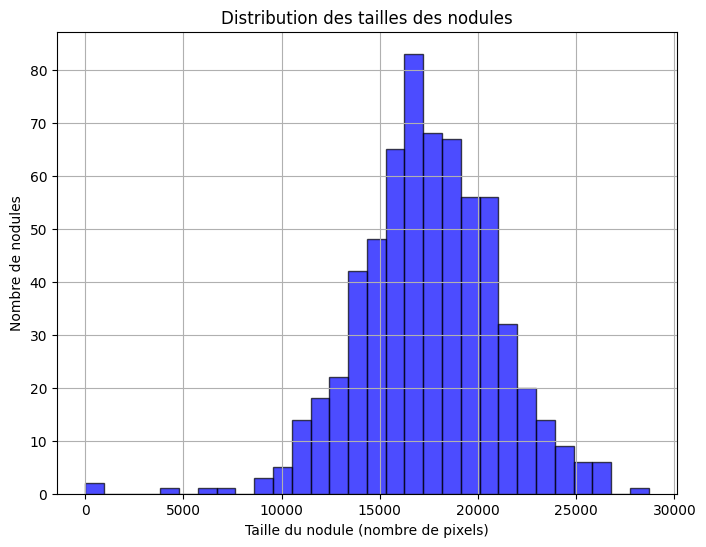

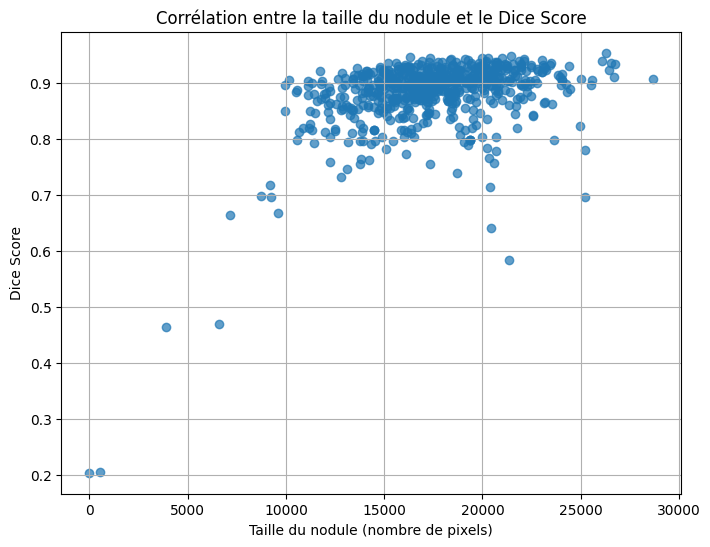

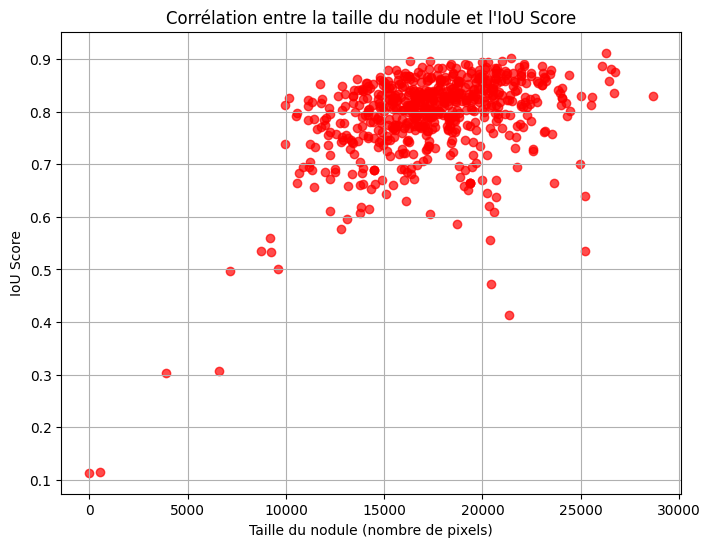

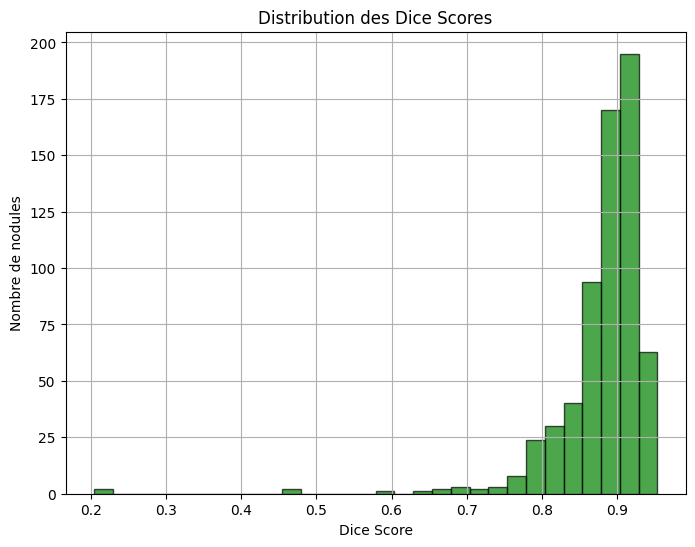

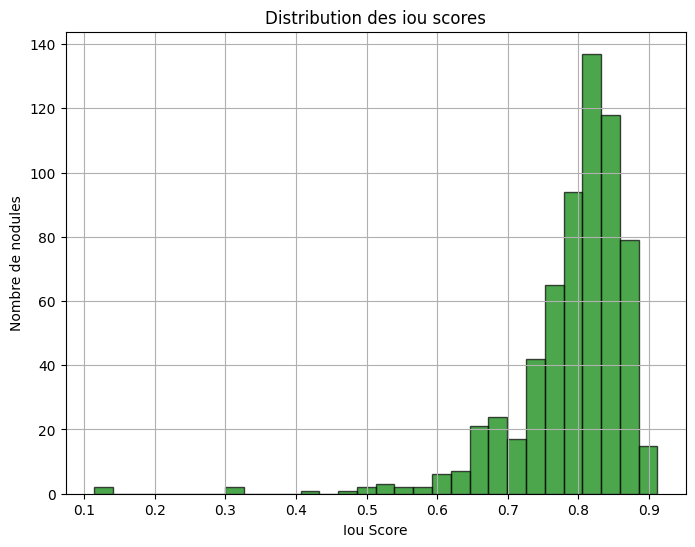

In [38]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os


# --- 1. Charger le modèle ---
def load_model(model_path, device):
    """
    Charge un modèle U-Net pré-entraîné pour la segmentation d'images.

    :param model_path: Chemin vers le fichier du modèle sauvegardé.
    :param device: Périphérique sur lequel charger le modèle (CPU ou GPU).
    :return: Modèle chargé en mode évaluation.
    """
    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


# --- 2. Préparer une image pour le test ---
def preprocess_image(image_path):
    """
    Pré-traite une image pour l'inférence du modèle.

    :param image_path: Chemin de l'image d'entrée.
    :return: Tenseur image pré-traité et image originale en format RGB.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    augmented = transform(image=image)
    image_tensor = augmented["image"].unsqueeze(0)
    return image_tensor, image


# --- 3. Effectuer la prédiction ---
def predict(model, image_tensor, device):
    """
    Effectue une prédiction de segmentation sur une image donnée.

    :param model: Modèle de segmentation.
    :param image_tensor: Image pré-traitée sous forme de tenseur.
    :param device: Périphérique sur lequel effectuer l'inférence.
    :return: Masque de segmentation prédit.
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()[0, 0]
    return output


# --- 4. Superposer le masque sur l'image ---
def overlay_mask(image, mask, alpha=0.5):
    """
    Superpose le masque prédit sur l'image originale.

    :param image: Image originale en format RGB.
    :param mask: Masque prédit.
    :param alpha: Coefficient de transparence du masque.
    :return: Image avec masque superposé.
    """
    mask = (mask > 0.5).astype(np.uint8)
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * 255
    blended = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return blended


# --- 5. Récupérer le masque de référence ---
def get_ground_truth_mask(original_image_filename):
    """
    Récupère le masque de vérité terrain correspondant à l'image d'origine.

    :param original_image_filename: Nom du fichier image d'origine.
    :return: Masque de vérité terrain si disponible, sinon None.
    """
    mask_filename = original_image_filename.replace("cropped.jpg", "mask.jpg")
    mask_filepath = os.path.join("../data/train_data/cropped_masks", mask_filename)
    if os.path.exists(mask_filepath):
        return cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE) / 255.0
    return None


# --- 6. Calcul des métriques ---
def dice_score(y_true, y_pred):
    """
    Calcule le Dice Score entre le masque de vérité terrain et le masque prédit.

    :param y_true: Masque de vérité terrain.
    :param y_pred: Masque prédit.
    :return: Dice Score.
    """
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))


def iou_score(y_true, y_pred):
    """
    Calcule le score d'intersection sur union (IoU) entre le masque de vérité terrain et le masque prédit.

    :param y_true: Masque de vérité terrain.
    :param y_pred: Masque prédit.
    :return: IoU Score.
    """
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union > 0 else 0


# --- 7. Visualisation des résultats ---
def visualize(original, mask, overlay, ground_truth=None):
    """
    Affiche les images et masques pour évaluation visuelle.

    :param original: Image originale.
    :param mask: Masque prédit.
    :param overlay: Image avec masque superposé.
    :param ground_truth: Masque de vérité terrain (optionnel).
    """
    plt.imshow(original)
    plt.title("Image Originale")
    plt.axis("off")
    plt.show()

    plt.imshow(mask, cmap="gray")
    plt.title("Masque Prédit")
    plt.axis("off")
    plt.show()

    if ground_truth is not None:
        plt.imshow(ground_truth, cmap="gray")
        plt.title("Masque Original (Ground Truth)")
        plt.axis("off")
        plt.show()

    plt.imshow(overlay)
    plt.title("Image + Masque")
    plt.axis("off")
    plt.show()


# --- 8. Analyse des performances en fonction de la taille du nodule ---
def analyze_performance(image_paths, model, device):
    """
    Analyse la performance du modèle en fonction de la taille des nodules segmentés.

    :param image_paths: Liste des chemins des images.
    :param model: Modèle de segmentation.
    :param device: Périphérique utilisé pour l'inférence.
    """
    sizes = []
    dice_scores = []
    iou_scores = []

    for image_path in image_paths:
        image_tensor, original_image = preprocess_image(image_path)
        predicted_mask = predict(model, image_tensor, device)
        ground_truth_mask = get_ground_truth_mask(os.path.basename(image_path))

        if ground_truth_mask is not None:
            dice_scores.append(dice_score(ground_truth_mask, predicted_mask))
            iou_scores.append(iou_score(ground_truth_mask, predicted_mask))
            sizes.append(np.sum(predicted_mask > 0.5))

    # Calculer les statistiques du Dice Score
    dice_mean = np.mean(dice_scores)
    dice_median = np.median(dice_scores)
    dice_std = np.std(dice_scores)
    dice_variance = np.var(dice_scores)

    print(f"Dice Score Moyenne: {dice_mean:.4f}")
    print(f"Dice Score Médiane: {dice_median:.4f}")
    print(f"Dice Score Écart-Type: {dice_std:.4f}")
    print(f"Dice Score Variance: {dice_variance:.4f}")

    iou_mean = np.mean(iou_scores)
    iou_median = np.median(iou_scores)
    iou_std = np.std(iou_scores)
    iou_variance = np.var(iou_scores)

    print(f"Iou Score Moyenne: {iou_mean:.4f}")
    print(f"Iou Score Médiane: {iou_median:.4f}")
    print(f"Iou Score Écart-Type: {iou_std:.4f}")
    print(f"Iou Score Variance: {iou_variance:.4f}")

    # Histogramme des tailles de nodules
    plt.figure(figsize=(8, 6))
    plt.hist(sizes, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des tailles des nodules")
    plt.grid(True)
    plt.show()

    # Scatter plot Taille vs Dice Score
    plt.figure(figsize=(8, 6))
    plt.scatter(sizes, dice_scores, alpha=0.7)
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("Dice Score")
    plt.title("Corrélation entre la taille du nodule et le Dice Score")
    plt.grid(True)
    plt.show()

    # Scatter plot Taille vs IoU Score
    plt.figure(figsize=(8, 6))
    plt.scatter(sizes, iou_scores, alpha=0.7, color='red')
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("IoU Score")
    plt.title("Corrélation entre la taille du nodule et l'IoU Score")
    plt.grid(True)
    plt.show()

    # --- Ajout de l'histogramme des Dice Scores ---
    plt.figure(figsize=(8, 6))
    plt.hist(dice_scores, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel("Dice Score")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des Dice Scores")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(iou_scores, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel("Iou Score")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des iou scores")
    plt.grid(True)
    plt.show()


# --- 9. Tester le modèle sur une image et analyser les performances ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "../models/unet_resnet50.pth"
    model = load_model(model_path, device)

    # Charger plusieurs images pour l'analyse
    image_folder = "../data/cropped_images"
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith("_cropped.jpg")]

    analyze_performance(image_paths, model, device)

### Entraînement modèle B

In [ ]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim


# --- 1. Définition du Dataset ---
class SegmentationDataset(Dataset):
    """
    Dataset personnalisé pour la segmentation d'images.

    Args:
        images_paths (list): Liste des chemins des images d'entrée.
        masks_paths (list): Liste des chemins des masques correspondants.
        transform (callable, optional): Transformations à appliquer aux images et masques.

    Methods:
        __len__: Retourne le nombre d'éléments dans le dataset.
        __getitem__: Charge et retourne une image et son masque transformés.

    Returns:
        tuple: (image, masque) sous forme de tenseurs PyTorch.
    """

    def __init__(self, images_paths, masks_paths, transform=None):
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        self.transform = transform

    def __len__(self):
        """Retourne le nombre d'échantillons dans le dataset."""
        return len(self.images_paths)

    def __getitem__(self, idx):
        """
        Charge une image et son masque correspondant, applique les transformations et retourne les tenseurs.

        Args:
            idx (int): Index de l'élément à récupérer.

        Returns:
            torch.Tensor: Image transformée.
            torch.Tensor: Masque transformé (normalisé entre 0 et 1).
        """
        image = cv2.imread(self.images_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = ToTensorV2()(image=image)['image']
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        mask = mask.float() / 255.0  # Normalisation 0-1
        return image, mask


# --- 2. Fonctions Utilitaires ---
def get_dataloaders(batch_size=8, num_workers=4):
    """
    Charge les images, divise le dataset en ensembles d'entraînement, validation et test,
    applique les transformations et retourne les DataLoaders.

    Args:
        batch_size (int, optional): Taille des lots d'entraînement. Par défaut 8.
        num_workers (int, optional): Nombre de workers pour le chargement des données. Par défaut 4.

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    images_paths = sorted(glob.glob(os.path.join("../data/train_data", "cropped_filtered_images", "*.jpg")))
    masks_paths  = sorted(glob.glob(os.path.join("../data/train_data", "cropped_masks", "*.jpg")))

    assert len(images_paths) == len(masks_paths), "Le nombre d'images et de masques doit être identique."

    # Division des données en ensembles d'entraînement (80%), validation (10%) et test (10%)
    train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(images_paths, masks_paths, test_size=0.2, random_state=42)
    val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5, random_state=42)

    # Définition des transformations
    train_transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # Création des datasets
    train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
    val_dataset   = SegmentationDataset(val_imgs, val_masks, transform=val_transform)
    test_dataset  = SegmentationDataset(test_imgs, test_masks, transform=val_transform)

    # Création des DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


def create_model():
    """
    Crée et retourne un modèle U-Net basé sur VGG16 pour la segmentation.

    Returns:
        torch.nn.Module: Modèle U-Net.
    """
    model = smp.Unet(
        encoder_name="vgg16",  # Utilisation de VGG16 comme encodeur
        encoder_weights="imagenet",  # Poids pré-entraînés sur ImageNet
        in_channels=3,  # 3 canaux pour les images RGB
        classes=1, # Une seule classe pour la segmentation binaire
        decoder_attention_type="scse"
    )
    return model


def train_model(model, train_loader, val_loader, device, num_epochs=30, lr=1e-4):
    """
    Entraîne le modèle U-Net et sauvegarde les poids après l'entraînement.

    Args:
        model (torch.nn.Module): Modèle de segmentation à entraîner.
        train_loader (DataLoader): DataLoader pour l'entraînement.
        val_loader (DataLoader): DataLoader pour la validation.
        device (torch.device): Périphérique sur lequel exécuter le modèle (CPU ou GPU).
        num_epochs (int, optional): Nombre d'époques d'entraînement. Par défaut 30.
        lr (float, optional): Taux d'apprentissage. Par défaut 1e-4.

    Returns:
        None
    """
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}")

    # --- Sauvegarde du modèle ---
    model_save_path = "../models/unet_vgg16.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Modèle sauvegardé à : {model_save_path}")


# --- 3. EXÉCUTION PRINCIPALE ---
if __name__ == '__main__':
    # Vérifier CUDA
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation du périphérique : {device}")
    if device.type == "cuda":
        print(f"Nombre de GPU : {torch.cuda.device_count()}")
        print(f"Nom du GPU : {torch.cuda.get_device_name(0)}")

    # Charger les données
    train_loader, val_loader, test_loader = get_dataloaders(batch_size=8, num_workers=4)

    # Créer le modèle
    model = create_model()

    # Entraîner le modèle
    train_model(model, train_loader, val_loader, device, num_epochs=30)

### Affichage du masque prédit modèle B

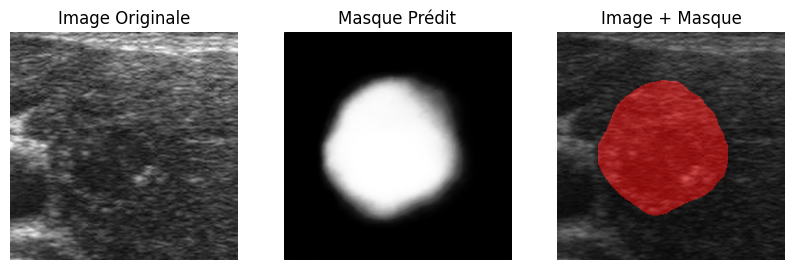

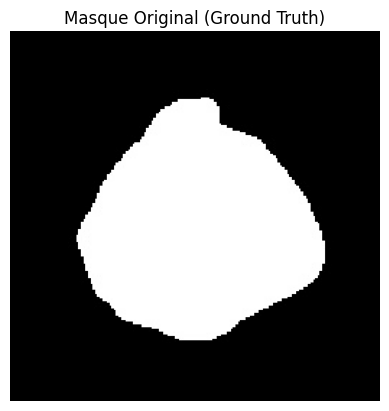

In [37]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os


# --- 1. Charger le modèle ---
def load_model(model_path, device):
    """
    Charge un modèle U-Net pré-entraîné à partir d'un fichier de poids.

    Args:
        model_path (str): Chemin vers le fichier contenant les poids du modèle.
        device (torch.device): Périphérique sur lequel charger le modèle (CPU ou GPU).

    Returns:
        torch.nn.Module: Modèle U-Net chargé en mode évaluation.
    """
    model = smp.Unet(
        encoder_name="vgg16",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


# --- 2. Préparer une image pour le test ---
def preprocess_image(image_path):
    """
    Charge et pré-traite une image pour l'inférence.

    Args:
        image_path (str): Chemin de l'image à tester.

    Returns:
        tuple:
            torch.Tensor: Image transformée prête pour le modèle (ajout d'une dimension batch).
            numpy.ndarray: Image originale en format RGB.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    augmented = transform(image=image)
    image_tensor = augmented["image"].unsqueeze(0)  # Ajout de la dimension batch
    return image_tensor, image


# --- 3. Effectuer la prédiction ---
def predict(model, image_tensor, device):
    """
    Effectue une prédiction de segmentation sur une image donnée.

    Args:
        model (torch.nn.Module): Modèle U-Net chargé.
        image_tensor (torch.Tensor): Image pré-traitée sous forme de tenseur.
        device (torch.device): Périphérique utilisé pour l'inférence.

    Returns:
        numpy.ndarray: Masque de segmentation prédit (grayscale, normalisé entre 0 et 1).
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # Appliquer la fonction sigmoïde pour obtenir une probabilité
        output = output.cpu().numpy()[0, 0]  # Extraction du masque 2D
    return output


# --- 4. Superposer le masque sur l'image ---
def overlay_mask(image, mask, alpha=0.5):
    """
    Superpose un masque de segmentation sur une image originale.

    Args:
        image (numpy.ndarray): Image originale en RGB.
        mask (numpy.ndarray): Masque de segmentation prédit.
        alpha (float, optional): Facteur de transparence du masque superposé (0 = invisible, 1 = opaque).

    Returns:
        numpy.ndarray: Image avec le masque superposé.
    """
    mask = (mask > 0.5).astype(np.uint8)  # Binarisation du masque (seuil à 0.5)
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * 255  # Rouge pour le masque
    blended = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return blended


# --- 5. Récupérer le masque de référence ---
def get_ground_truth_mask(original_image_filename):
    """
    Récupère le masque de segmentation réel (ground truth) correspondant à une image.

    Args:
        original_image_filename (str): Nom du fichier de l'image test.

    Returns:
        numpy.ndarray or None: Masque de segmentation réel normalisé entre 0 et 1, ou None si absent.
    """
    mask_filename = original_image_filename.replace("cropped.jpg", "mask.jpg")
    mask_filepath = os.path.join("../data/train_data/cropped_masks", mask_filename)

    if os.path.exists(mask_filepath):
        return cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalisation entre 0 et 1
    return None


# --- 6. Visualisation des résultats ---
def visualize(original, mask, overlay, ground_truth=None):
    """
    Affiche l'image originale, le masque prédit et la superposition des deux.

    Args:
        original (numpy.ndarray): Image originale en RGB.
        mask (numpy.ndarray): Masque de segmentation prédit.
        overlay (numpy.ndarray): Image avec le masque superposé.
        ground_truth (numpy.ndarray, optional): Masque de segmentation réel (facultatif).

    Returns:
        None
    """
    plt.figure(figsize=(10, 4))

    # Image originale
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Image Originale")
    plt.axis("off")

    # Masque prédit
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque Prédit")
    plt.axis("off")

    # Superposition
    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Image + Masque")
    plt.axis("off")

    plt.show()

    # Affichage du masque ground truth s'il est disponible
    if ground_truth is not None:
        plt.figure()
        plt.imshow(ground_truth, cmap="gray")
        plt.title("Masque Original (Ground Truth)")
        plt.axis("off")
        plt.show()


# --- 7. Tester le modèle sur une image et afficher le résultat ---
if __name__ == "__main__":
    """
    Exécute un test d'inférence en chargeant un modèle, effectuant une prédiction sur une image
    et affichant les résultats.
    """
    # Détection du périphérique (CPU/GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Chargement du modèle
    model_path = "../models/unet_vgg16.pth"
    model = load_model(model_path, device)

    # Sélection d'une image test
    test_image_path = "../data/cropped_images/11_1_region0_cropped.jpg"
    image_tensor, original_image = preprocess_image(test_image_path)

    # Prédiction du masque
    predicted_mask = predict(model, image_tensor, device)

    # Superposition du masque sur l'image
    overlayed_image = overlay_mask(original_image, predicted_mask)

    # Chargement du masque de référence (ground truth)
    ground_truth_mask = get_ground_truth_mask(os.path.basename(test_image_path))

    # Affichage des résultats
    visualize(original_image, predicted_mask, overlayed_image, ground_truth_mask)

### Affichage des performances du modèle B

Dice Score Moyenne: 0.8731
Dice Score Médiane: 0.8826
Dice Score Écart-Type: 0.0454
Dice Score Variance: 0.0021
Iou Score Moyenne: 0.7775
Iou Score Médiane: 0.7898
Iou Score Écart-Type: 0.0677
Iou Score Variance: 0.0046


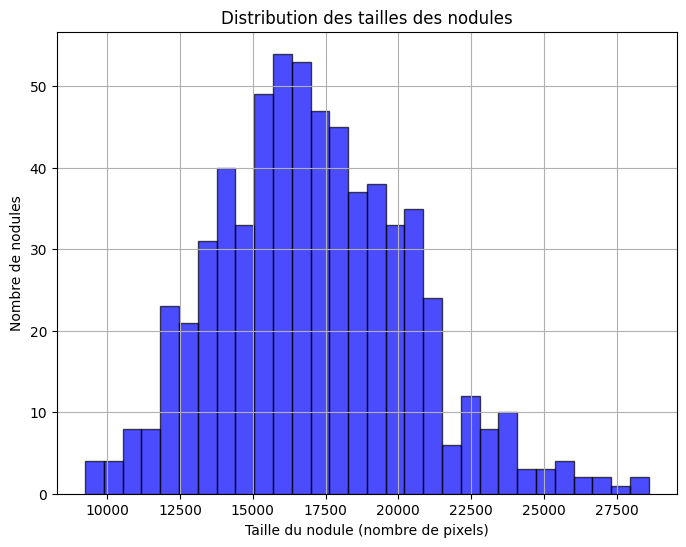

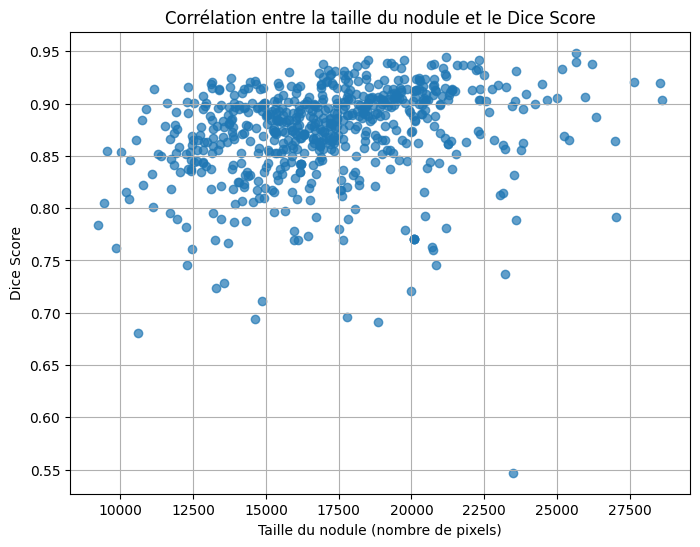

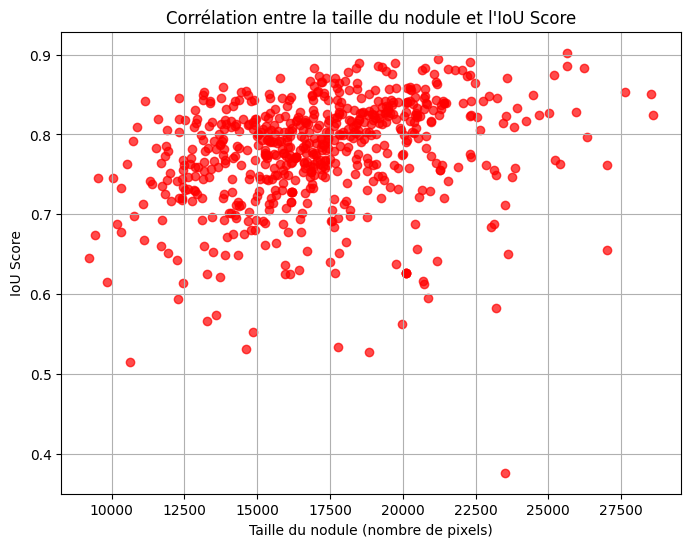

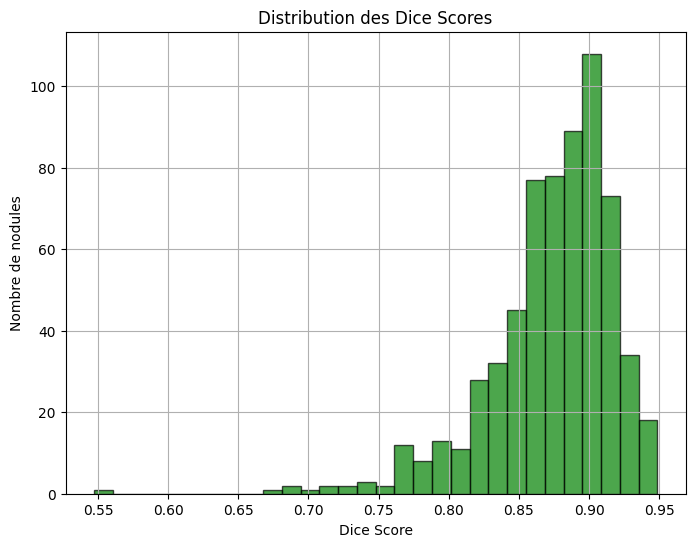

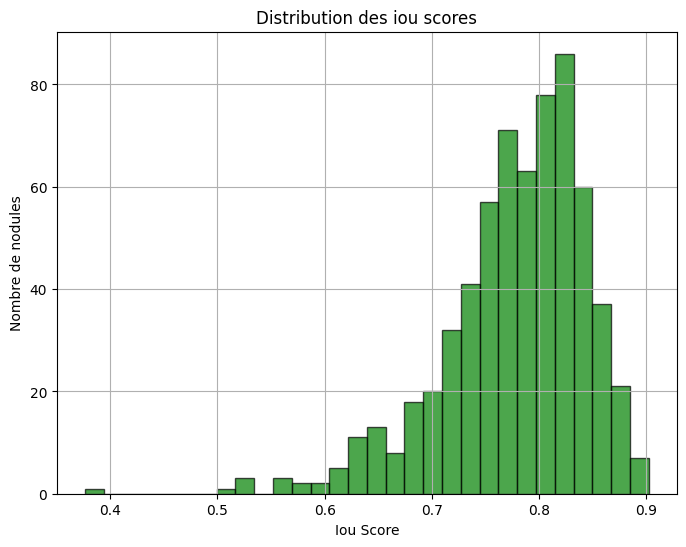

In [36]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os


# --- 1. Charger le modèle ---
def load_model(model_path, device):
    """
    Charge un modèle U-Net pré-entraîné à partir d'un fichier de poids.

    Args:
        model_path (str): Chemin vers le fichier contenant les poids du modèle.
        device (torch.device): Périphérique sur lequel charger le modèle (CPU ou GPU).

    Returns:
        torch.nn.Module: Modèle U-Net chargé en mode évaluation.
    """
    model = smp.Unet(
        encoder_name="vgg16",
        encoder_weights=None,
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


# --- 2. Préparer une image pour le test ---
def preprocess_image(image_path):
    """
    Charge et pré-traite une image pour l'inférence.

    Args:
        image_path (str): Chemin de l'image à tester.

    Returns:
        tuple:
            torch.Tensor: Image transformée sous forme de tenseur avec une dimension batch.
            numpy.ndarray: Image originale en format RGB.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    augmented = transform(image=image)
    image_tensor = augmented["image"].unsqueeze(0)
    return image_tensor, image


# --- 3. Effectuer la prédiction ---
def predict(model, image_tensor, device):
    """
    Effectue une prédiction de segmentation sur une image donnée.

    Args:
        model (torch.nn.Module): Modèle U-Net chargé.
        image_tensor (torch.Tensor): Image pré-traitée sous forme de tenseur.
        device (torch.device): Périphérique utilisé pour l'inférence.

    Returns:
        numpy.ndarray: Masque de segmentation prédit (grayscale, normalisé entre 0 et 1).
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = output.cpu().numpy()[0, 0]  # Extraction du masque 2D
    return output


# --- 4. Superposer le masque sur l'image ---
def overlay_mask(image, mask, alpha=0.5):
    """
    Superpose un masque de segmentation sur une image originale.

    Args:
        image (numpy.ndarray): Image originale en RGB.
        mask (numpy.ndarray): Masque de segmentation prédit.
        alpha (float, optional): Facteur de transparence du masque superposé (0 = invisible, 1 = opaque).

    Returns:
        numpy.ndarray: Image avec le masque superposé.
    """
    mask = (mask > 0.5).astype(np.uint8)  # Binarisation du masque
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 0] = mask * 255  # Rouge pour le masque
    blended = cv2.addWeighted(image, 1 - alpha, mask_colored, alpha, 0)
    return blended


# --- 5. Récupérer le masque de référence ---
def get_ground_truth_mask(original_image_filename):
    """
    Récupère le masque de segmentation réel (ground truth) correspondant à une image.

    Args:
        original_image_filename (str): Nom du fichier de l'image test.

    Returns:
        numpy.ndarray or None: Masque de segmentation réel normalisé entre 0 et 1, ou None si absent.
    """
    mask_filename = original_image_filename.replace("cropped.jpg", "mask.jpg")
    mask_filepath = os.path.join("../data/train_data/cropped_masks", mask_filename)

    if os.path.exists(mask_filepath):
        return cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalisation entre 0 et 1
    return None


# --- 6. Calcul des métriques ---
def dice_score(y_true, y_pred):
    """
    Calcule le Dice Score entre le masque réel et le masque prédit.

    Args:
        y_true (numpy.ndarray): Masque réel (ground truth).
        y_pred (numpy.ndarray): Masque prédit.

    Returns:
        float: Dice Score (valeur entre 0 et 1).
    """
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))


def iou_score(y_true, y_pred):
    """
    Calcule l'Intersection over Union (IoU) entre le masque réel et le masque prédit.

    Args:
        y_true (numpy.ndarray): Masque réel.
        y_pred (numpy.ndarray): Masque prédit.

    Returns:
        float: IoU Score (valeur entre 0 et 1).
    """
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union > 0 else 0


# --- 7. Analyse des performances en fonction de la taille du nodule ---
def analyze_performance(image_paths, model, device):
    """
    Analyse les performances du modèle en fonction de la taille des nodules.

    Args:
        image_paths (list): Liste des chemins des images à analyser.
        model (torch.nn.Module): Modèle de segmentation.
        device (torch.device): Périphérique utilisé pour l'inférence.

    Returns:
        None: Affiche les métriques et des graphiques.
    """
    sizes = []  # Taille des nodules en pixels
    dice_scores = []
    iou_scores = []

    for image_path in image_paths:
        image_tensor, original_image = preprocess_image(image_path)
        predicted_mask = predict(model, image_tensor, device)
        ground_truth_mask = get_ground_truth_mask(os.path.basename(image_path))

        if ground_truth_mask is not None:
            dice = dice_score(ground_truth_mask, predicted_mask)
            iou = iou_score(ground_truth_mask, predicted_mask)
            size = np.sum(predicted_mask > 0.5)  # Nombre de pixels segmentés

            sizes.append(size)
            dice_scores.append(dice)
            iou_scores.append(iou)

    # Calculer les statistiques du Dice Score
    dice_mean = np.mean(dice_scores)
    dice_median = np.median(dice_scores)
    dice_std = np.std(dice_scores)
    dice_variance = np.var(dice_scores)

    print(f"Dice Score Moyenne: {dice_mean:.4f}")
    print(f"Dice Score Médiane: {dice_median:.4f}")
    print(f"Dice Score Écart-Type: {dice_std:.4f}")
    print(f"Dice Score Variance: {dice_variance:.4f}")

    iou_mean = np.mean(iou_scores)
    iou_median = np.median(iou_scores)
    iou_std = np.std(iou_scores)
    iou_variance = np.var(iou_scores)

    print(f"Iou Score Moyenne: {iou_mean:.4f}")
    print(f"Iou Score Médiane: {iou_median:.4f}")
    print(f"Iou Score Écart-Type: {iou_std:.4f}")
    print(f"Iou Score Variance: {iou_variance:.4f}")

    # Histogramme des tailles de nodules
    plt.figure(figsize=(8, 6))
    plt.hist(sizes, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des tailles des nodules")
    plt.grid(True)
    plt.show()

    # Scatter plot Taille vs Dice Score
    plt.figure(figsize=(8, 6))
    plt.scatter(sizes, dice_scores, alpha=0.7)
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("Dice Score")
    plt.title("Corrélation entre la taille du nodule et le Dice Score")
    plt.grid(True)
    plt.show()

    # Scatter plot Taille vs IoU Score
    plt.figure(figsize=(8, 6))
    plt.scatter(sizes, iou_scores, alpha=0.7, color='red')
    plt.xlabel("Taille du nodule (nombre de pixels)")
    plt.ylabel("IoU Score")
    plt.title("Corrélation entre la taille du nodule et l'IoU Score")
    plt.grid(True)
    plt.show()

    # --- Ajout de l'histogramme des Dice Scores ---
    plt.figure(figsize=(8, 6))
    plt.hist(dice_scores, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel("Dice Score")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des Dice Scores")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(iou_scores, bins=30, alpha=0.7, color='green', edgecolor='black')
    plt.xlabel("Iou Score")
    plt.ylabel("Nombre de nodules")
    plt.title("Distribution des iou scores")
    plt.grid(True)
    plt.show()


# --- 9. Tester le modèle sur une image et analyser les performances ---
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "../models/unet_vgg16.pth"
    model = load_model(model_path, device)

    # Charger plusieurs images pour l'analyse
    image_folder = "../data/cropped_images"
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith("_cropped.jpg")]

    # Analyser la performance du modèle en fonction de la taille des nodules
    analyze_performance(image_paths, model, device)